### If the notebook does not fully load, please access it using the NBViewer located at the link below:
https://nbviewer.jupyter.org/github/carkar7/Unsupervised-Model-Development-with-Medical-Provider-Data/blob/master/Unsupervised%20Model%20Development%20with%20Medical%20Provider%20Data.ipynb


# Introduction
These are the results of a project to generate an unsupervised learning model using medical provider data provided by the Centers of Medicaid and Medicare services. The approach I took was to identify clusters using a K-means algorithm.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

#### Reading in the data

In [2]:
dataset = pd.read_table('Medicare_Provider_Util_Payment_PUF_CY2015.txt')

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Setting up pandas environment to show all columns

In [3]:
# set up display area to show dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 100)

dataset.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_entity_code,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,nppes_provider_zip,nppes_provider_state,nppes_provider_country,provider_type,medicare_participation_indicator,place_of_service,hcpcs_code,hcpcs_description,hcpcs_drug_indicator,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt
0,1,CPT copyright 2014 American Medical Associatio...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,2.15022e+08,MD,US,Internal Medicine,Y,F,99217,Hospital observation care discharge,N,23.0,23.0,23.0,72.680000,328.000000,54.502609,55.280870
2,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,2.15022e+08,MD,US,Internal Medicine,Y,F,99219,Hospital observation care typically 50 minutes,N,18.0,18.0,18.0,135.850000,614.000000,100.958889,102.348889
3,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,2.15022e+08,MD,US,Internal Medicine,Y,F,99221,"Initial hospital inpatient care, typically 30 ...",N,59.0,58.0,59.0,101.365085,333.288136,79.469661,80.859831
4,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,2.15022e+08,MD,US,Internal Medicine,Y,F,99222,"Initial hospital inpatient care, typically 50 ...",N,132.0,130.0,132.0,139.010455,356.492424,107.933409,107.969621


#### Filtering the data based on the parameters provided in the email, that is to only include “Pain Management” provider types and providers within the state of California (“CA”).

In [4]:
dataset_filtered = dataset[(dataset['provider_type']=='Pain Management') & (dataset['nppes_provider_state'] == 'CA')]

#### Checking for duplicates

In [5]:
if len(dataset_filtered[dataset_filtered.duplicated(keep=False)])<1:
    print("No duplicate records")

No duplicate records


#### Scanning through all variables to get an idea of the different values within

In [1]:
for x in dataset_filtered.columns:
    print(x)
    print(dataset_filtered[x].value_counts(normalize=True).round(5)*100,'\n')

nppes_entity_code is "I" for all records, making this variable irrelevant and will be dropped.
Similarly nppes_provider_state, nppes_provider_country, provider_type, medicare_participation_indicator can all be dropped at this point due to no variance

In [7]:
removed = ['nppes_entity_code', 'nppes_provider_state', 'nppes_provider_country',\
          'provider_type', 'medicare_participation_indicator' ]

dataset_filtered = dataset_filtered.drop(removed, axis=1)

dataset_filtered.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,nppes_provider_zip,place_of_service,hcpcs_code,hcpcs_description,hcpcs_drug_indicator,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt
12454,1003077157,SNIDERMAN,MICHAEL,I,MD,M,1500 SAN PABLO ST,NaN,LOS ANGELES,9.00335e+08,F,00790,Anesthesia for procedure in upper abdomen incl...,N,11.0,11.0,11.0,390.468182,2102.272727,294.077273,278.408182
12455,1003077157,SNIDERMAN,MICHAEL,I,MD,M,1500 SAN PABLO ST,NaN,LOS ANGELES,9.00335e+08,F,00840,Anesthesia for procedure in lower abdominal ca...,N,14.0,14.0,14.0,317.600000,1700.892857,248.997857,235.965000
12456,1003077157,SNIDERMAN,MICHAEL,I,MD,M,1500 SAN PABLO ST,NaN,LOS ANGELES,9.00335e+08,F,27096,Injection procedure into sacroiliac joint for ...,N,14.0,13.0,14.0,116.979286,520.000000,89.853571,63.917143
12457,1003077157,SNIDERMAN,MICHAEL,I,MD,M,1500 SAN PABLO ST,NaN,LOS ANGELES,9.00335e+08,F,36620,Insertion of arterial catheter for blood sampl...,N,24.0,24.0,24.0,55.535000,180.000000,42.540833,41.841250
12458,1003077157,SNIDERMAN,MICHAEL,I,MD,M,1500 SAN PABLO ST,NaN,LOS ANGELES,9.00335e+08,F,62311,Injections of substances into lower or sacral ...,N,18.0,17.0,18.0,85.923333,800.000000,63.651111,63.598889


In [8]:
dataset_filtered['nppes_credentials'].value_counts()

M.D.            1348
MD               849
D.O.             126
M.D               61
M.D., M.B.A       46
DO                36
M.D., M.P.H.      28
M.D., PHD         20
M. D.             10
D.O                7
DDS                6
M.D. & PH.D.       4
M.D., L.AC.        2
Name: nppes_credentials, dtype: int64

These values should be consolodated into three groups, "MD", "DO", "DDS". Those with "None" will be imputed with the mode (MD).

In [9]:
dataset_filtered['nppes_credentials_recode'] = dataset_filtered['nppes_credentials'].str.replace('.','').str.replace(' ','').str.replace(',MBA','').str.replace(',MPH','').str.replace(',PHD','').str.replace(',LAC','').str.replace('&PHD','').str.replace('None','MD')
dataset_filtered['nppes_credentials_recode'].value_counts()

MD     2368
DO      169
DDS       6
Name: nppes_credentials_recode, dtype: int64

#### At this point, I'm dropping all redundant variables.
Address information is not needed so long as we retain the city
Names can be a good proxy for gender, however, that's not necessary given that we already have that.


In [10]:
dataset_filtered2= dataset_filtered.drop(['nppes_provider_street1', 'nppes_provider_street2', 'nppes_provider_zip',\
                                          'nppes_provider_mi','nppes_provider_first_name','hcpcs_description',\
                                         'nppes_provider_first_name','nppes_provider_last_org_name',\
                                         'nppes_credentials'], axis=1)

### Feature engineering categorical variables
I'm listing all the categorical variables to find ways to group them by looking at their values

In [11]:
num_cols = dataset_filtered2._get_numeric_data().columns

for x in dataset_filtered2.columns:
    if x in num_cols:
        pass
    else:
        print(x)
        print(dataset_filtered2[x].value_counts(normalize=True).round(2)*100,'\n')

nppes_provider_gender
M    91.0
F     9.0
Name: nppes_provider_gender, dtype: float64 

nppes_provider_city
SAN DIEGO           6.0
LOS ANGELES         4.0
SACRAMENTO          4.0
BAKERSFIELD         4.0
CARLSBAD            3.0
THOUSAND OAKS       3.0
SANTA ROSA          3.0
RANCHO MIRAGE       3.0
SANTA BARBARA       3.0
REDDING             3.0
IRVINE              3.0
SAN FRANCISCO       2.0
SANTA CRUZ          2.0
NAPA                2.0
BEVERLY HILLS       2.0
WALNUT CREEK        2.0
PLEASANT HILL       2.0
CHICO               2.0
SANTA MONICA        2.0
MONTEREY            2.0
LOMA LINDA          2.0
MISSION VIEJO       2.0
EL DORADO HILLS     2.0
WESTMINSTER         2.0
FULLERTON           1.0
TORRANCE            1.0
SANTA ANA           1.0
EUREKA              1.0
FOLSOM              1.0
LANCASTER           1.0
MURRIETA            1.0
HUNTINGTON BEACH    1.0
APTOS               1.0
PASADENA            1.0
VENTURA             1.0
SAN CARLOS          1.0
NORTHRIDGE          1.0
FREM

Since the algorithm that I will be using is KMeans, it can be rather ambiguous as to how it interprets categorical variables. With that said, I've chosen to add some ordinal information to the variables by recoding their based on their relative frequency. 

To do this, I've stored the value_count series into a variable and turned it into a dictionary for mapping

In [12]:
y = dataset_filtered2['nppes_provider_city'].value_counts(normalize=True).round(2)*100

mapping = {}
for ind, value in y.items():
    mapping[ind]=value

print(mapping)

{'SAN DIEGO': 6.0, 'LOS ANGELES': 4.0, 'SACRAMENTO': 4.0, 'BAKERSFIELD': 4.0, 'CARLSBAD': 3.0, 'THOUSAND OAKS': 3.0, 'SANTA ROSA': 3.0, 'RANCHO MIRAGE': 3.0, 'SANTA BARBARA': 3.0, 'REDDING': 3.0, 'IRVINE': 3.0, 'SAN FRANCISCO': 2.0, 'SANTA CRUZ': 2.0, 'NAPA': 2.0, 'BEVERLY HILLS': 2.0, 'WALNUT CREEK': 2.0, 'PLEASANT HILL': 2.0, 'CHICO': 2.0, 'SANTA MONICA': 2.0, 'MONTEREY': 2.0, 'LOMA LINDA': 2.0, 'MISSION VIEJO': 2.0, 'EL DORADO HILLS': 2.0, 'WESTMINSTER': 2.0, 'FULLERTON': 1.0, 'TORRANCE': 1.0, 'SANTA ANA': 1.0, 'EUREKA': 1.0, 'FOLSOM': 1.0, 'LANCASTER': 1.0, 'MURRIETA': 1.0, 'HUNTINGTON BEACH': 1.0, 'APTOS': 1.0, 'PASADENA': 1.0, 'VENTURA': 1.0, 'SAN CARLOS': 1.0, 'NORTHRIDGE': 1.0, 'FREMONT': 1.0, 'ARCADIA': 1.0, 'PALM DESERT': 1.0, 'LOS ALTOS': 1.0, 'SAN LUIS OBISPO': 1.0, 'FRESNO': 1.0, 'CAMPBELL': 1.0, 'PLEASANTON': 1.0, 'PALMDALE': 1.0, 'POMONA': 1.0, 'APPLE VALLEY': 1.0, 'DOWNEY': 1.0, 'NEWPORT BEACH': 1.0, 'ALHAMBRA': 1.0, 'HERMOSA BEACH': 1.0, 'LAGUNA HILLS': 1.0, 'HEMET': 1

In [13]:
dataset_filtered2['nppes_provider_city_recode']=dataset_filtered2['nppes_provider_city'].map(mapping)

In [14]:
dataset_filtered2['nppes_provider_city_recode'].value_counts()

1.0    847
2.0    600
3.0    486
4.0    300
0.0    172
6.0    142
Name: nppes_provider_city_recode, dtype: int64

In [15]:
y2 = dataset_filtered2['hcpcs_code'].value_counts(normalize=True).round(2)*100

mapping2 = {}
for ind, value in y2.items():
    mapping2[ind]=value

print(mapping2)

{'99214': 6.0, '99213': 5.0, '99204': 4.0, '64483': 4.0, '64493': 4.0, '62311': 4.0, '64494': 3.0, '64484': 3.0, '20610': 3.0, '27096': 3.0, '77003': 3.0, '62310': 2.0, '99144': 2.0, '64635': 2.0, '99203': 2.0, '64636': 2.0, '64495': 2.0, '99215': 2.0, '64490': 1.0, '99205': 1.0, '76942': 1.0, '20553': 1.0, 'G0434': 1.0, '20552': 1.0, 'J1885': 1.0, 'J3301': 1.0, '64491': 1.0, 'J3490': 1.0, '96372': 1.0, '77002': 1.0, '99212': 1.0, '20611': 1.0, 'J1100': 1.0, 'J1030': 1.0, '64492': 1.0, 'J1040': 1.0, '99232': 1.0, '72275': 1.0, '64633': 1.0, '62368': 1.0, '64634': 1.0, '62370': 1.0, '99223': 0.0, 'J0702': 0.0, 'G0431': 0.0, '64450': 0.0, '62369': 0.0, '64479': 0.0, '64405': 0.0, '99231': 0.0, '99211': 0.0, '72100': 0.0, '99233': 0.0, '99222': 0.0, '95972': 0.0, 'J1020': 0.0, '72265': 0.0, '63650': 0.0, 'J2250': 0.0, '64640': 0.0, '64480': 0.0, '82570': 0.0, 'G6042': 0.0, '62319': 0.0, 'G6056': 0.0, '00740': 0.0, '95970': 0.0, '20550': 0.0, '01996': 0.0, 'G6053': 0.0, 'G6044': 0.0, '9588

In [16]:
dataset_filtered2['hcpcs_code_recode']=dataset_filtered2['hcpcs_code'].map(mapping2)
dataset_filtered2['hcpcs_code_recode'].value_counts()

0.0    622
1.0    572
4.0    403
3.0    365
2.0    323
6.0    144
5.0    118
Name: hcpcs_code_recode, dtype: int64

In [17]:
X_cleaned=dataset_filtered2

X_cleaned.head()

,npi,nppes_provider_gender,nppes_provider_city,place_of_service,hcpcs_code,hcpcs_drug_indicator,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt,nppes_credentials_recode,nppes_provider_city_recode,hcpcs_code_recode
12454,1003077157,M,LOS ANGELES,F,00790,N,11.0,11.0,11.0,390.468182,2102.272727,294.077273,278.408182,MD,4.0,0.0
12455,1003077157,M,LOS ANGELES,F,00840,N,14.0,14.0,14.0,317.600000,1700.892857,248.997857,235.965000,MD,4.0,0.0
12456,1003077157,M,LOS ANGELES,F,27096,N,14.0,13.0,14.0,116.979286,520.000000,89.853571,63.917143,MD,4.0,3.0
12457,1003077157,M,LOS ANGELES,F,36620,N,24.0,24.0,24.0,55.535000,180.000000,42.540833,41.841250,MD,4.0,0.0
12458,1003077157,M,LOS ANGELES,F,62311,N,18.0,17.0,18.0,85.923333,800.000000,63.651111,63.598889,MD,4.0,4.0


####  Unique Id
Doing some research on Google and I was able to confirm my suspicion that 'npi' was a unique identifier -- "National Provider Identifier (NPI)". With that said, I removed it so as to not introduce more noise into the algorithm. I've also removed the original city and hcpcs variables since I've already recoded them earlier.

In [18]:
X_cleaned= X_cleaned.drop(['npi','nppes_provider_city','hcpcs_code'], axis=1)

### Dummy Variables
I will now dummy code the remaining categorical variables. I did not encode them based on frequency like I did with others because these only contained a few values.

In [19]:
X_cleaned = pd.get_dummies(X_cleaned,drop_first=False)

#### Checking to see if their are any missing values

In [20]:
X_cleaned.isnull().sum()

line_srvc_cnt                    0
bene_unique_cnt                  0
bene_day_srvc_cnt                0
average_Medicare_allowed_amt     0
average_submitted_chrg_amt       0
average_Medicare_payment_amt     0
average_Medicare_standard_amt    0
nppes_provider_city_recode       0
hcpcs_code_recode                0
nppes_provider_gender_F          0
nppes_provider_gender_M          0
place_of_service_F               0
place_of_service_O               0
hcpcs_drug_indicator_N           0
hcpcs_drug_indicator_Y           0
nppes_credentials_recode_DDS     0
nppes_credentials_recode_DO      0
nppes_credentials_recode_MD      0
dtype: int64

#### Converting to float

In [21]:
X_cleaned= X_cleaned.astype(float)
X_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2547 entries, 12454 to 9435646
Data columns (total 18 columns):
line_srvc_cnt                    2547 non-null float64
bene_unique_cnt                  2547 non-null float64
bene_day_srvc_cnt                2547 non-null float64
average_Medicare_allowed_amt     2547 non-null float64
average_submitted_chrg_amt       2547 non-null float64
average_Medicare_payment_amt     2547 non-null float64
average_Medicare_standard_amt    2547 non-null float64
nppes_provider_city_recode       2547 non-null float64
hcpcs_code_recode                2547 non-null float64
nppes_provider_gender_F          2547 non-null float64
nppes_provider_gender_M          2547 non-null float64
place_of_service_F               2547 non-null float64
place_of_service_O               2547 non-null float64
hcpcs_drug_indicator_N           2547 non-null float64
hcpcs_drug_indicator_Y           2547 non-null float64
nppes_credentials_recode_DDS     2547 non-null float64
nppes_

### Determining the number of clusters
By calculating the within cluster sum of squares (WCSS) for 10 iterations of clusters in our model, we can select the optimal number of clusters. In this case, the elbow appears to be at 5.

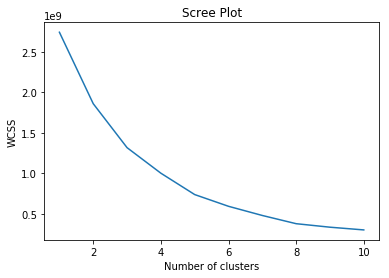

In [22]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler as mms

X= X_cleaned
wcss = []
for i in range(1,11):
    Kmeans = KMeans(n_clusters = i, init='k-means++', max_iter=300, n_init=10, random_state=1)
    Kmeans.fit(X_cleaned)
    wcss.append(Kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Scree Plot')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [23]:
kmeans = KMeans(n_clusters = 5, init='k-means++', max_iter=300, n_init=10, random_state=1)

y_kmeans = kmeans.fit_predict(X)

### This is will serve as my guide for comparing different variable indexes in the following plots

In [24]:
for ix, col in enumerate(X.columns):
    print(ix,col)

0 line_srvc_cnt
1 bene_unique_cnt
2 bene_day_srvc_cnt
3 average_Medicare_allowed_amt
4 average_submitted_chrg_amt
5 average_Medicare_payment_amt
6 average_Medicare_standard_amt
7 nppes_provider_city_recode
8 hcpcs_code_recode
9 nppes_provider_gender_F
10 nppes_provider_gender_M
11 place_of_service_F
12 place_of_service_O
13 hcpcs_drug_indicator_N
14 hcpcs_drug_indicator_Y
15 nppes_credentials_recode_DDS
16 nppes_credentials_recode_DO
17 nppes_credentials_recode_MD


#### Plotting out various scatter plots to evaluate at glance any outlier clusters their hcpcs and beneficiary utilization information

There definitely appears to be some outiers clusters, particularly Cluster 0 (see Charts 2-6) and Cluster 4 (see Chart 0).

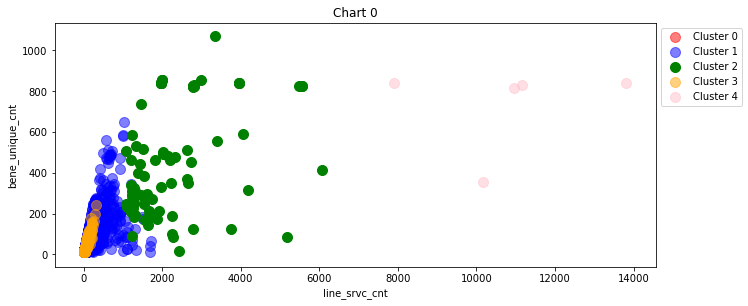

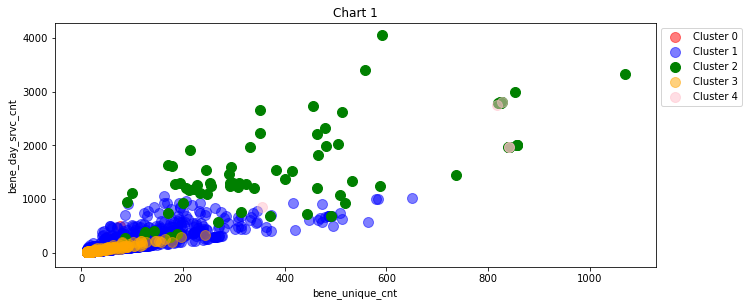

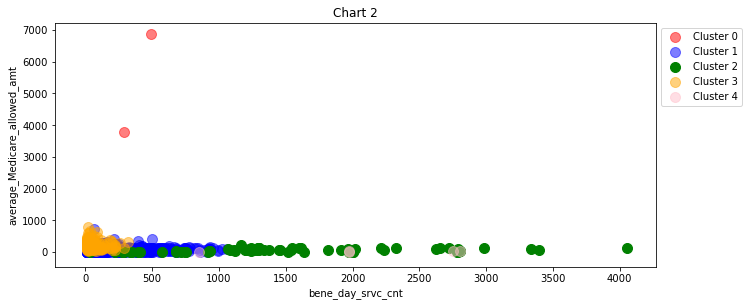

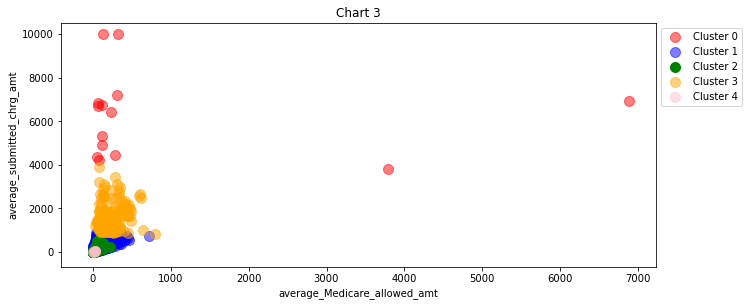

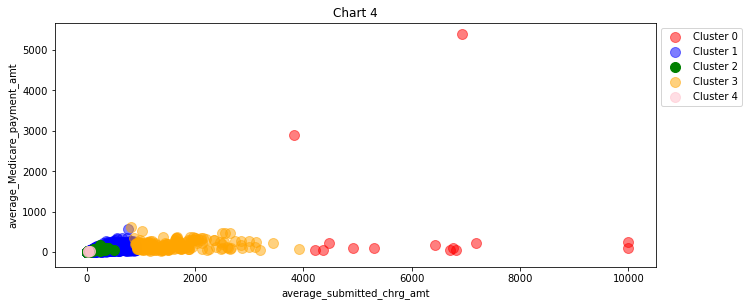

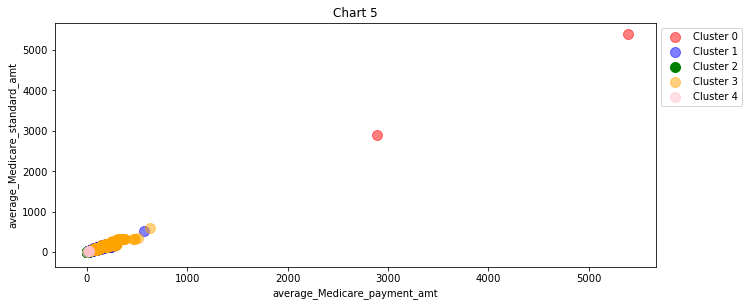

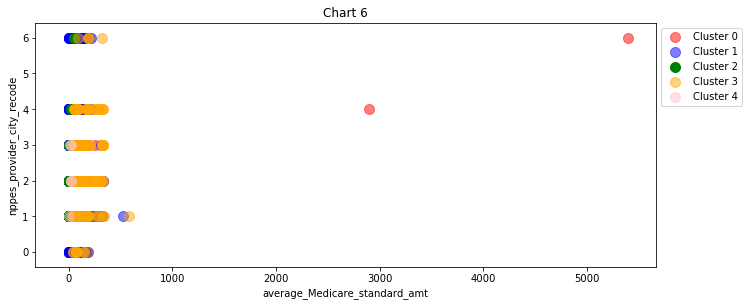

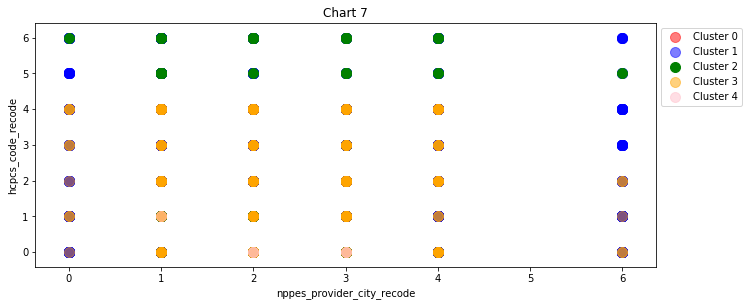

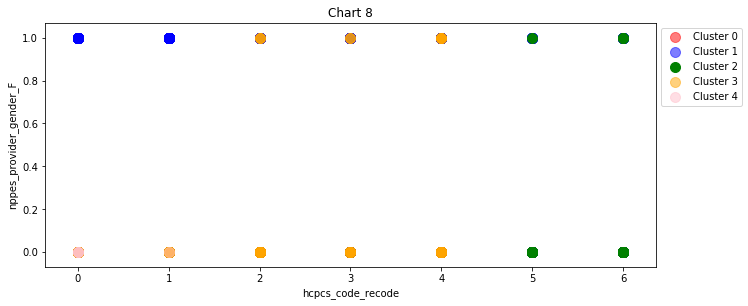

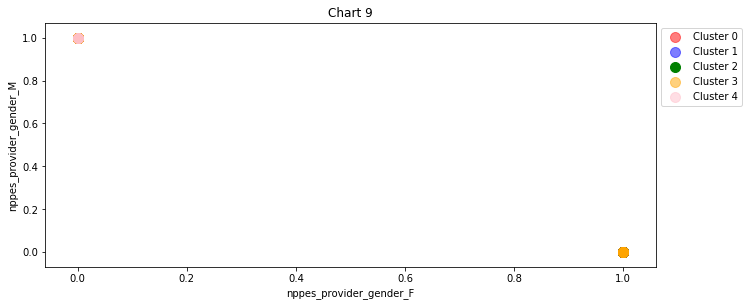

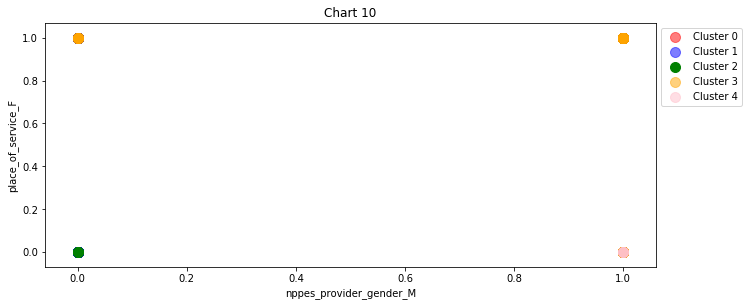

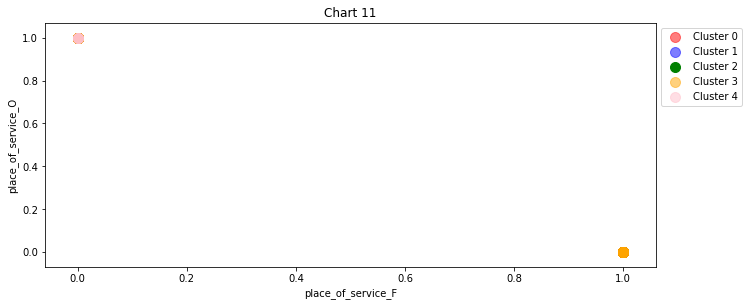

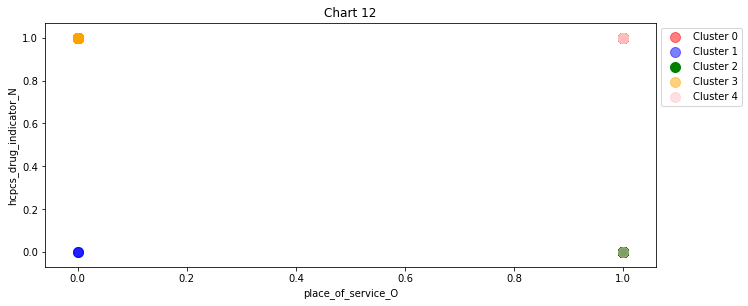

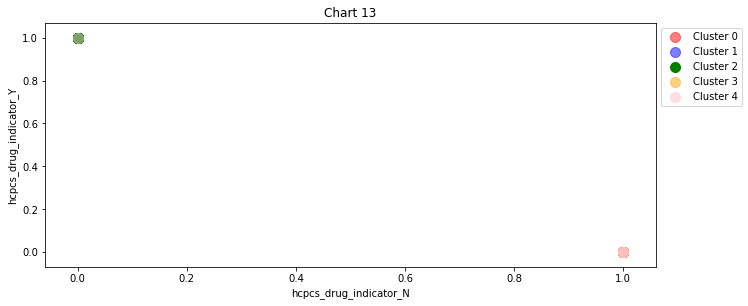

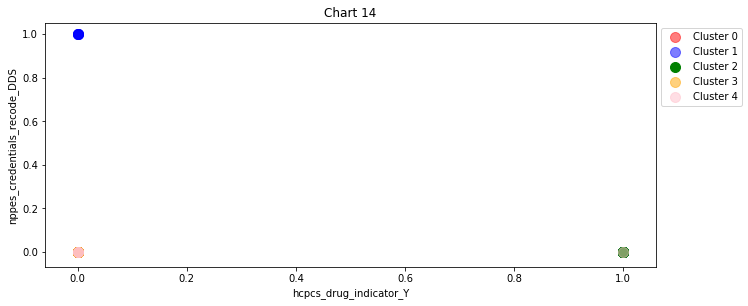

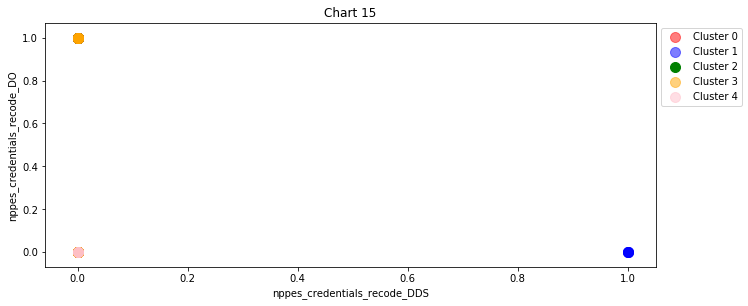

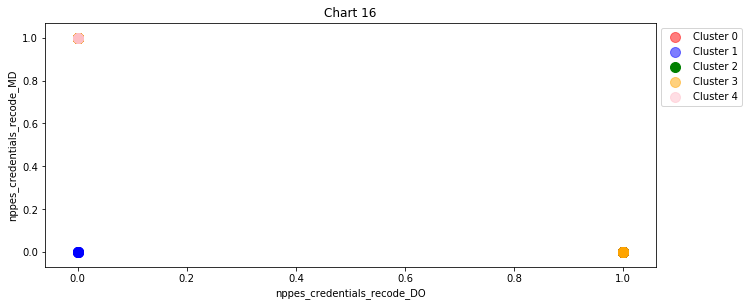

In [25]:
for ix, col in enumerate(X.columns):
    if ix < len(X.columns)-1:
        plt.figure(1,figsize=(11,6))
        
        plt.scatter(X[y_kmeans == 0].iloc[:,ix], X[y_kmeans == 0].iloc[:,ix+1], s=100, c='red',alpha=.5, label='Cluster 0')
        plt.scatter(X[y_kmeans == 1].iloc[:,ix], X[y_kmeans == 1].iloc[:,ix+1], s=100, c='blue', alpha=.5,label='Cluster 1')
        plt.scatter(X[y_kmeans == 2].iloc[:,ix], X[y_kmeans == 2].iloc[:,ix+1], s=100, c='green', alpha=1,label='Cluster 2')
        plt.scatter(X[y_kmeans == 3].iloc[:,ix], X[y_kmeans == 3].iloc[:,ix+1], s=100, c='orange',alpha=.5, label='Cluster 3')
        plt.scatter(X[y_kmeans == 4].iloc[:,ix], X[y_kmeans == 4].iloc[:,ix+1], s=100, c='pink', alpha=.5,label='Cluster 4')

        plt.title('Chart {}'.format(ix))
        plt.xlabel(X.columns[ix])
        plt.ylabel(X.columns[ix+1])
        plt.legend(loc='upper left', prop={'size':10}, bbox_to_anchor=(1,1))
        plt.tight_layout(pad=7)
        plt.show()
        
    else:
        pass

#### I'm going to explore cluster 0 a bit further given that it consistently deviates from other clusters on multiple comparisons.

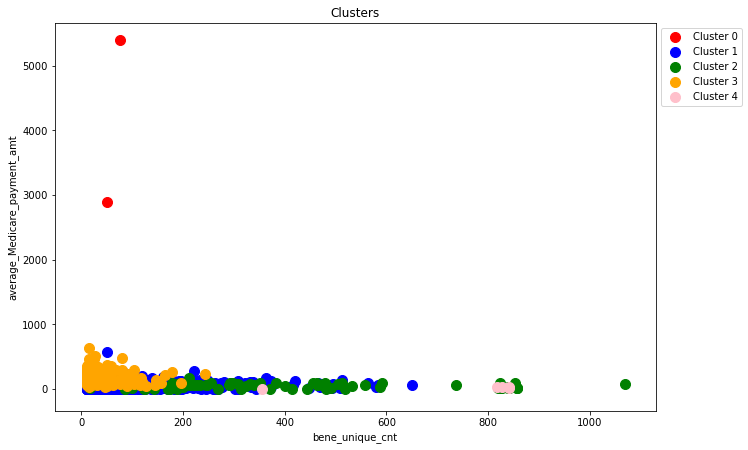

In [26]:
plt.figure(1,figsize=(11,8))

plt.scatter(X[y_kmeans == 0].iloc[:,1], X[y_kmeans == 0].iloc[:,5], s=100, c='red', label='Cluster 0')
plt.scatter(X[y_kmeans == 1].iloc[:,1], X[y_kmeans == 1].iloc[:,5], s=100, c='blue', label='Cluster 1')
plt.scatter(X[y_kmeans == 2].iloc[:,1], X[y_kmeans == 2].iloc[:,5], s=100, c='green', label='Cluster 2')
plt.scatter(X[y_kmeans == 3].iloc[:,1], X[y_kmeans == 3].iloc[:,5], s=100, c='orange', label='Cluster 3')
plt.scatter(X[y_kmeans == 4].iloc[:,1], X[y_kmeans == 4].iloc[:,5], s=100, c='pink', label='Cluster 4')

plt.title('Clusters')
plt.xlabel(X.columns[1])
plt.ylabel(X.columns[5])
plt.legend(loc='upper left', prop={'size':10}, bbox_to_anchor=(1,1))
plt.tight_layout(pad=7)
plt.show()

### Adding the cluster outputs to an early dataframe to evaluate differences

In [27]:
dataset_filtered['clusters'] = y_kmeans

In [28]:
dataset_filtered.groupby(['clusters']).mean()

,npi,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt
clusters,,,,,,,,
0,1.691304e+09,115.428571,42.000000,108.500000,898.939999,6280.161467,697.965458,688.421523
1,1.452624e+09,126.974469,59.061003,108.057840,95.240320,314.354206,72.931205,64.950571
2,1.545961e+09,2263.545977,473.896552,1671.942529,54.496422,125.085901,42.255661,40.581908
3,1.410867e+09,55.114035,38.442982,53.855263,218.692513,1518.614058,168.774982,143.490782
4,1.635169e+09,10798.800000,736.600000,2070.600000,19.092694,37.200434,18.628303,17.085688


### Cluster 0

It appears that the two data points in cluster 0 that have been consistently deviating from other clusters is the result of 2 points (index 6523071 & 5623080) where average_submitted_chr_amt was equal $10,000 for the implantation of nerve neurostimulators, both conducted by Dr. Alexander Hersel in Thousand Oaks.

In [29]:
data_cluster_0 = dataset_filtered[dataset_filtered['clusters']==0]
data_cluster_0

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,nppes_provider_zip,place_of_service,hcpcs_code,hcpcs_description,hcpcs_drug_indicator,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt,nppes_credentials_recode,clusters
1464153,1154382463,FULLER,NICHOLAS,S,MD,M,120 S SPALDING DR,SUITE 301,BEVERLY HILLS,902121800,F,64635,Destruction of lower or sacral spinal facet jo...,N,14.0,14.0,14.0,307.860000,7192.928571,233.131429,166.987857,MD,0
6523069,1689696718,HERSEL,ALEXANDER,P,M.D.,M,1120 NEWBURY RD,SUITE 150,THOUSAND OAKS,913203663,F,62310,Injections of substances into upper or middle ...,N,71.0,47.0,71.0,113.014648,5309.859155,88.607324,87.552254,MD,0
6523070,1689696718,HERSEL,ALEXANDER,P,M.D.,M,1120 NEWBURY RD,SUITE 150,THOUSAND OAKS,913203663,F,62311,Injections of substances into lower or sacral ...,N,209.0,131.0,209.0,79.639665,4205.741627,61.906938,61.767225,MD,0
6523071,1689696718,HERSEL,ALEXANDER,P,M.D.,M,1120 NEWBURY RD,SUITE 150,THOUSAND OAKS,913203663,F,63650,Implantation of spinal neurostimulator electro...,N,32.0,13.0,17.0,318.202812,10000.000000,249.469687,256.457812,MD,0
6523072,1689696718,HERSEL,ALEXANDER,P,M.D.,M,1120 NEWBURY RD,SUITE 150,THOUSAND OAKS,913203663,F,64483,Injections of anesthetic and/or steroid drug i...,N,115.0,73.0,115.0,122.949826,4908.695652,94.586435,91.340348,MD,0
6523073,1689696718,HERSEL,ALEXANDER,P,M.D.,M,1120 NEWBURY RD,SUITE 150,THOUSAND OAKS,913203663,F,64484,Injections of anesthetic and/or steroid drug i...,N,68.0,41.0,52.0,54.960000,4360.294118,42.471618,42.121324,MD,0
6523077,1689696718,HERSEL,ALEXANDER,P,M.D.,M,1120 NEWBURY RD,SUITE 150,THOUSAND OAKS,913203663,F,64493,Injections of lower or sacral spine facet join...,N,52.0,30.0,52.0,119.216923,6759.615385,91.308846,73.030192,MD,0
6523078,1689696718,HERSEL,ALEXANDER,P,M.D.,M,1120 NEWBURY RD,SUITE 150,THOUSAND OAKS,913203663,F,64494,Injections of lower or sacral spine facet join...,N,47.0,28.0,47.0,69.567021,6712.765957,53.196809,43.830213,MD,0
6523079,1689696718,HERSEL,ALEXANDER,P,M.D.,M,1120 NEWBURY RD,SUITE 150,THOUSAND OAKS,913203663,F,64495,Injections of lower or sacral spine facet join...,N,43.0,25.0,43.0,71.477442,6813.953488,54.546047,44.565581,MD,0
6523080,1689696718,HERSEL,ALEXANDER,P,M.D.,M,1120 NEWBURY RD,SUITE 150,THOUSAND OAKS,913203663,F,64555,Implantation of peripheral nerve neurostimulat...,N,59.0,16.0,41.0,136.355763,10000.000000,106.906271,106.827458,MD,0


### Cluster 2 

Appears to have a large mean 'bene_day_srvc_cnt'. I think this may have something to do with service centers seeing as there is a common HCPCS description of "'Established patient office" throughout this cluster. Furthermore, looking back at Chart 7 above, there appears to be a prevalence of Cluster 2 along less frequently occurring cities in the dataset. This may be indicative of patient visits to the doctors office in non-central office locations

In [30]:
data_cluster_2 = dataset_filtered[dataset_filtered['clusters']==2]
data_cluster_2

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,nppes_provider_zip,place_of_service,hcpcs_code,hcpcs_description,hcpcs_drug_indicator,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt,nppes_credentials_recode,clusters
730485,1073672473,MILLER,NATHAN,A,MD,M,6221 METROPOLITAN ST,SUITE 201,CARLSBAD,920093096,O,99214,Established patient office or other outpatient...,N,1237.0,255.0,1237.0,113.127801,208.200000,83.205764,82.867728,MD,2
1527810,1164419073,PARMAR,ASHOK,M,M.D.,M,8325 BRIMHALL RD STE 100,NaN,BAKERSFIELD,93312,O,80299,Quantitation of therapeutic drug,N,2017.0,492.0,679.0,18.640000,50.000000,18.215682,18.269995,MD,2
1527819,1164419073,PARMAR,ASHOK,M,M.D.,M,8325 BRIMHALL RD STE 100,NaN,BAKERSFIELD,93312,O,99213,Established patient office or other outpatient...,N,1338.0,533.0,1338.0,72.438102,275.963206,50.056031,51.069761,MD,2
1527821,1164419073,PARMAR,ASHOK,M,M.D.,M,8325 BRIMHALL RD STE 100,NaN,BAKERSFIELD,93312,O,99214,Established patient office or other outpatient...,N,1071.0,509.0,1071.0,107.227591,332.843137,73.318375,77.460850,MD,2
1675020,1174630453,LOWENSTEIN,MICHAEL,H,MD,M,"1901 E. FOURTH STREET, SUITE 210",NaN,SANTA ANA,92705,O,97112,Therapeutic procedure to re-educate brain-to-n...,N,1230.0,90.0,935.0,30.891350,35.158537,23.800033,23.079528,MD,2
1675021,1174630453,LOWENSTEIN,MICHAEL,H,MD,M,"1901 E. FOURTH STREET, SUITE 210",NaN,SANTA ANA,92705,O,97140,Manual (physical) therapy techniques to 1 or m...,N,2243.0,99.0,1120.0,23.773562,35.133749,18.399140,19.027882,MD,2
1716337,1184609885,TRAN,PHONG,H,M.D.,M,15606 BROOKHURST ST,SUITE A,WESTMINSTER,926837581,O,99214,Established patient office or other outpatient...,N,2323.0,479.0,2323.0,121.210499,230.247955,87.561253,78.569983,MD,2
1716340,1184609885,TRAN,PHONG,H,M.D.,M,15606 BROOKHURST ST,SUITE A,WESTMINSTER,926837581,O,J1020,"Injection, methylprednisolone acetate, 20 mg",Y,2139.0,481.0,1980.0,3.012366,20.000000,2.343787,2.343787,MD,2
1716342,1184609885,TRAN,PHONG,H,M.D.,M,15606 BROOKHURST ST,SUITE A,WESTMINSTER,926837581,O,J1885,"Injection, ketorolac tromethamine, per 15 mg",Y,2629.0,371.0,682.0,0.643576,25.000000,0.501373,0.501373,MD,2
1753920,1184683252,VOONG,CALVON,NaN,M.D.,M,800 W CENTER AVE,NaN,VISALIA,932916014,O,99213,Established patient office or other outpatient...,N,1209.0,207.0,1209.0,75.184541,123.870968,52.219752,53.263615,MD,2


### Cluster 4

Tends to have the highest means of all the clusters in 'line_srvc_cnt', 'bene_unique_cnt', and 'bene_day_srvc_cnt'. I'm not sure what these variable mean, but the HCPCS description mentions Opiate drugs. I'm currently aware of a massive opioid epidemic and wonder if these doctors are providing related services. 

In [31]:
data_cluster_4 = dataset_filtered[dataset_filtered['clusters']==4]
data_cluster_4

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,nppes_provider_zip,place_of_service,hcpcs_code,hcpcs_description,hcpcs_drug_indicator,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt,nppes_credentials_recode,clusters
3366000,1356353247,SOLONIUK,LEONARD,J,M.D.,M,2111 AIRPARK DR,NaN,REDDING,960012433,O,G6056,"Opiate(s), drug and metabolites, each procedure",N,7892.0,841.0,1973.0,26.480000,30.000000,25.939478,20.978332,MD,4
3366001,1356353247,SOLONIUK,LEONARD,J,M.D.,M,2111 AIRPARK DR,NaN,REDDING,960012433,O,G6058,"Drug confirmation, each procedure",N,13812.0,841.0,1974.0,16.144038,18.775702,15.815424,16.911373,MD,4
5301647,1558479352,BRADLEY,KENNETH,S,MD,M,4201 TORRANCE BLVD,SUITE 590,TORRANCE,905034536,O,J3301,"Injection, triamcinolone acetonide, not other...",Y,10172.0,355.0,852.0,1.779434,24.976406,1.386183,1.386183,MD,4
9037770,1952328494,GRIGSBY,ERIC,J,M.D.,M,3434 VILLA LN,SUITE 150,NAPA,945586405,O,82542,Chemical analysis using chromatography technique,N,11163.0,828.0,2802.0,24.580000,56.252799,24.054261,20.650250,MD,4
9037796,1952328494,GRIGSBY,ERIC,J,M.D.,M,3434 VILLA LN,SUITE 150,NAPA,945586405,O,G6056,"Opiate(s), drug and metabolites, each procedure",N,10955.0,818.0,2752.0,26.480000,55.997262,25.946168,25.502300,MD,4
